In [1]:
import numpy as np, sympy as sp, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn import preprocessing

np.random.seed = 1234

sp.init_printing(use_latex='mathjax')
%matplotlib inline

# Exploratory part

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [4]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [5]:
train.groupby('type').describe()

bone_length                                                    \
             count      mean       std       min       25%       50%   
type                                                                   
Ghost        117.0  0.347466  0.117748  0.061032  0.269748  0.340442   
Ghoul        129.0  0.517159  0.120600  0.200753  0.439625  0.515397   
Goblin       125.0  0.429650  0.101917  0.208625  0.355313  0.430797   

                           hair_length              ...        id         \
             75%       max       count      mean    ...       75%    max   
type                                                ...                    
Ghost   0.417253  0.622371       117.0  0.373186    ...     641.0  896.0   
Ghoul   0.590384  0.817001       129.0  0.655550    ...     708.0  897.0   
Goblin  0.492438  0.678519       125.0  0.544581    ...     661.0  886.0   

       rotting_flesh                                                    \
               count      mean       std       min       25%       50%   
type                                                                     
Ghost          117.0  0.593759  0.142150  0.165539  0.504399  0.603780   
Ghoul          129.0  0.490515  0.115357  0.172182  0.417474  0.491497   
Goblin         125.0  0.442357  0.140284  0.095687  0.341187  0.457490   

                            
             75%       max  
type                        
Ghost   0.682687  0.932466  
Ghoul   0.561786  0.779153  
Goblin  0.530852  0.840049  

[3 rows x 40 columns]

## Visualization

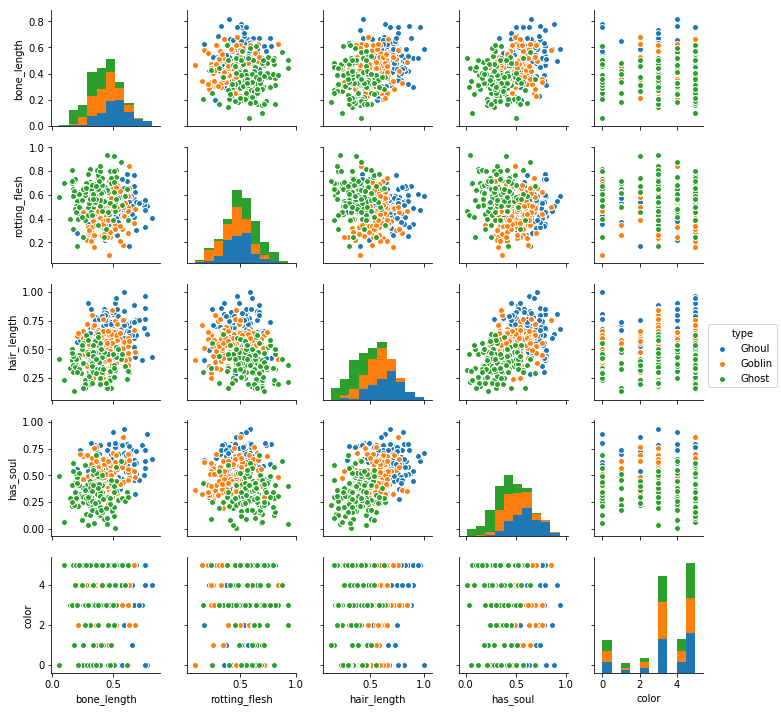

In [6]:
colorenc = preprocessing.LabelEncoder()
colorenc.fit(pd.concat((test['color'], train['color'])))
test['color'] = colorenc.transform(test['color'])
train['color'] = colorenc.transform(train['color'])

sns.pairplot(train.drop('id', axis=1), size=2, hue='type')
# plt.savefig('monsters_distribution.png', dpi=1200)

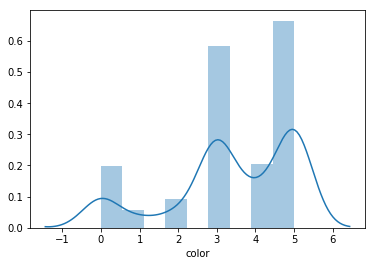

In [30]:
sns.distplot(train['color'])

From these plots one can see that the classes
are quite separated and form ellipsoid-like clusters
(though some of them are rather concave)
and the intuitive decision boundaries
can be linearized by introducing **polynomial features** of degree $3$. Then simple **logistic regression** or more complex model like **random forest** can be applied.

It is also obvious from visualization
that **K-nearest-neighbours** and **kernel density estimates** would give pretty good results.

# Building predictive models on plain data
## Simplest logit

In [7]:
monsterenc = preprocessing.LabelEncoder()
monsterenc.fit(train['type'])
train['type'] = monsterenc.transform(train['type'])

In [8]:
from sklearn.model_selection import cross_val_score
poly_features = preprocessing.PolynomialFeatures(3)

X_tr, y_tr = train.drop(['id', 'type'], axis=1), train['type']
X_tr = poly_features.fit_transform(X_tr)

In [9]:
from sklearn.linear_model import LogisticRegression

typelogfit = LogisticRegression()
scores = cross_val_score(typelogfit, X_tr, y_tr)
# for simplicity, let's train on the whole set
typelogfit.fit(X_tr, y_tr)
print('scores: %s\nmean score: %s' % (scores, scores.mean()))
print('coefs l2 norms: %s' % np.sqrt(
    typelogfit.coef_.dot(
        typelogfit.coef_.transpose()).diagonal()))

scores: [ 0.73387097  0.73387097  0.71544715]
mean score: 0.727729696652
coefs l2 norms: [ 3.48631155  3.60946858  4.3883833 ]


In [10]:
X_te = poly_features.fit_transform(test.drop(['id'], axis=1))
y_te = typelogfit.predict(X_te)
ans_logit = pd.DataFrame({'id': test['id'], 'type': monsterenc.inverse_transform(y_te)})
ans_logit.to_csv('ans_logit.csv', index=False)
ans_logit.head()

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghost
4,13,Ghost


Even this quite primitive technique performed surprisingly well!
The kaggle scored this solution $0.73724$ which is close
to the output of `cross_val_score`

Now let's see what else can be told about the quality of our model

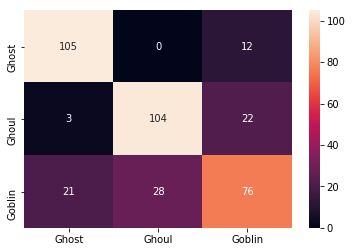

In [11]:
from sklearn.metrics import confusion_matrix
y_tr_pr = typelogfit.predict(X_tr)
cm = pd.DataFrame(confusion_matrix(y_tr, y_tr_pr),
                  index=monsterenc.classes_,
                  columns=monsterenc.classes_)
sns.heatmap(cm, annot=True, fmt="d")

## Nearest Neighbours models

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV


/home/god/.venv/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/god/.venv/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


score: 0.7547169811320755
n_neighbors: 53
weights: uniform
better to use $l\_1 $-norm


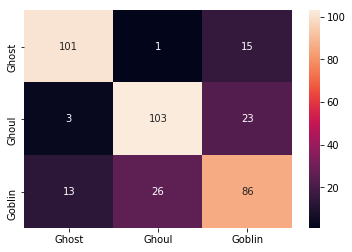

In [24]:
X_tr, y_tr = train.drop(['id', 'type', 'color'], axis=1), train['type']

knn = KNeighborsClassifier()
grid = GridSearchCV(knn,
                    param_grid={
                        'weights': ['uniform', 'distance'],
                        'n_neighbors': list(range(1,101,1)),
                        'p': [1,2]
                    })

grid.fit(X_tr, y_tr)
print('score: %s' % grid.best_score_)
print('n_neighbors: %s' % grid.best_estimator_.n_neighbors)
print('weights: %s' % grid.best_estimator_.weights)
print('better to use $l\\_%s $-norm' % grid.best_estimator_.p)
y_tr_pr = grid.predict(X_tr)
cm = pd.DataFrame(confusion_matrix(y_tr, y_tr_pr),
                  index=monsterenc.classes_,
                  columns=monsterenc.classes_)
sns.heatmap(cm, annot=True, fmt="d")

In [27]:
X_te = test.drop(['id', 'color'], axis=1)
y_te = grid.predict(X_te)
ans_knn = pd.DataFrame({'id': test['id'], 'type': monsterenc.inverse_transform(y_te)})
ans_knn.to_csv('ans_knn.csv', index=False)
ans_knn.head()

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghost
4,13,Ghost


Doesn't seem like a hell of an impovement...

## SVC

In [16]:
from sklearn.svm import SVC

In [23]:
X_tr, y_tr = train.drop(['id', 'type', 'color'], axis=1), train['type']
X_tr = preprocessing.PolynomialFeatures(2).fit_transform(X_tr)

svc = SVC()
grid = GridSearchCV(svc,
                    param_grid={
                        'C': [10**k for k in range(6)],
                        'kernel': ['poly', 'sigmoid', 'rbf'],
                    })
grid.fit(X_tr, y_tr)
display(grid)
grid.best_score_

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000, 10000, 100000], 'kernel': ['poly', 'sigmoid', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

0.7547169811320755

In [21]:
from sklearn.ensemble import RandomForestClassifier

X_tr, y_tr = train.drop(['id', 'type', 'color'], axis=1), train['type']
X_tr = preprocessing.PolynomialFeatures(2).fit_transform(X_tr)

rfc = RandomForestClassifier()
rfc.fit(X_tr, y_tr)
cross_val_score(rfc, X_tr, y_tr)

array([ 0.71774194,  0.7016129 ,  0.71544715])

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_tr,
                     rfc.predict(X_tr),
                     target_names=monsterenc.classes_))

             precision    recall  f1-score   support

      Ghost       0.98      0.98      0.98       117
      Ghoul       0.99      0.98      0.99       129
     Goblin       0.97      0.98      0.97       125

avg / total       0.98      0.98      0.98       371



In [20]:
X_te = test.drop(['id'], axis=1)
X_te, X_te_clr = X_te.drop('color', axis=1), X_te['color']

X_te_clr = clr_bin.transform(X_te_clr)
X_te_clr = pd.DataFrame(X_te_clr, columns=colorenc.classes_)
X_te = pd.concat((X_te, X_te_clr), axis=1)
X_te = preprocessing.PolynomialFeatures(2).fit_transform(X_te)
X_te = preprocessing.scale(X_te)

y_te = rfc.predict(X_te)
ans_rfc = pd.DataFrame({'id': test['id'],
                        'type': monsterenc.inverse_transform(y_te)})
ans_rfc.to_csv('ans_rfc.csv', index=False)